<a href="https://colab.research.google.com/github/flying-bear/Style-Transfer/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Once Block (mostly for colab) 

## Install libraries

In [ ]:
from IPython.display import clear_output 

!pip install pytorch_lightning
clear_output()

## Download Data

In [ ]:
# Download to Colab from YaDisk
from IPython.display import clear_output 
import os, sys, json
import urllib.parse as ul
import pathlib

# Delete Colab folder with files
# import shutil
# shutil.rmtree(dest, ignore_errors=True)

def download_from_yadisk(url, path):
  """Download from yadisk by link like 'https://disk.yandex.com/d/20pYBTBAKTQo-w'"""
  base_url = 'https://cloud-api.yandex.net:443/v1/disk/public/resources/download?public_key='
  pathlib.Path(path).mkdir(exist_ok=True, parents=True) 

  res = os.popen('wget -qO - {}{}'.format(base_url, url)).read()
  json_res = json.loads(res)
  filename = ul.parse_qs(ul.urlparse(json_res['href']).query)['filename'][0]
  os.system("wget '{}' -P '{}' -O '{}'".format(json_res['href'], path, filename))

  !unzip -j $filename -d $path 
  clear_output()

In [ ]:
import tqdm

def preprocess_dataset(input_path, output_path, transform):
  input_path = pathlib.Path(input_path)
  output_path = pathlib.Path(output_path)
  output_path.mkdir(exist_ok=True, parents=True)
  for file in tqdm.tqdm(list(input_path.iterdir())):
      image = cv2.imread(str(file))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      save_image(transform(image), output_path / file.name)

In [ ]:
download_from_yadisk('https://disk.yandex.ru/d/M9gq8P4lKT0ohQ', 'dataset/div2k')

In [ ]:
import torchvision.transforms as T
import cv2
from torchvision.utils import save_image

SIZE = 512 

transform = T.Compose([
  T.ToTensor(),
  T.Resize(SIZE),
])

# preprocess_dataset('dataset/div2k','dataset/div2k-prp', transform)

# Imports and General Functions

In [ ]:
# More informative CUDA errors
%env CUDA_LAUNCH_BLOCKING=1

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.utils import save_image

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule

In [ ]:
import datetime
import pathlib
import uuid

if IN_COLAB:
#   drive.mount('/content/drive')
  checkpoints_path = pathlib.Path('/content/drive/MyDrive/style-transfer/checkpoints')
  # checkpoints_path.mkdir(exist_ok=True, parents=True)


def get_timecoded_name(model):
  time_code = datetime.datetime.now().strftime("%y%m%d-%H%M%S") 
  model_name = model.__class__.__name__
  return model_name + '-' + time_code 


def get_file_size_mb(path):
  return path.stat().st_size / 1024 / 1024


def save_checkpoint(model, path=checkpoints_path):
  name = get_timecoded_name(model) + '.pth'
  path = pathlib.Path(path) / name
  torch.save(model.state_dict(), str(path))
  print(f'>> {str(path)} | {get_file_size_mb(path):.2f} MB')

In [ ]:
def load_picture(path='exms/1.jpg'):
    transform = T.Compose([
      T.ToTensor(),
      T.ConvertImageDtype(torch.float),
    ])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    return image

def render(image):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Datasets

In [ ]:
class RandomCropsDataset(Dataset):
  def __init__(self, path, width=512, crop=(224, 224)):
    self.files = [str(file) for file in pathlib.Path(path).iterdir()]
    if width is not None:
      self.transform = T.Compose([
        T.ToTensor(),
        T.Resize(width),
        T.RandomCrop(crop),
        T.ConvertImageDtype(torch.float),
      ])
    else:
      self.transform = T.Compose([
        T.ToTensor(),
        # T.Resize(width),
        T.RandomCrop(crop),
        T.ConvertImageDtype(torch.float),
      ])

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    try:
      image = cv2.imread(self.files[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0
    except:
      print(f'failed to read {self.files[idx]}')
      image = cv2.imread(self.file[0])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0


class ContentStyleDataset(Dataset):
  """Return a random pair of (content, style)""" 
  def __init__(self, content_dataset, style_dataset, pairs_per_epoch=1000):
    self.content = content_dataset 
    self.style = style_dataset 
    self.size = pairs_per_epoch 

  def __len__(self):
    return self.size 

  def __getitem__(self, idx):
    i = np.random.randint(0, len(self.content))
    j = np.random.randint(0, len(self.style))
    content, _ = self.content[i]
    style, _ = self.style[j]
    return content, style

In [ ]:
def show_dataset(dataset, n=6):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=n, num_workers=0, shuffle=True)
  images, classes = next(iter(data_loader))
  fig = plt.figure(figsize=(16, 8))
  if len(classes.shape) == 1:
    plt.imshow(torch.cat([images[i] for i in range(n)], 2).permute(1, 2, 0))
  else:
    first_row = torch.cat([images[i] for i in range(n)], 2)
    second_row = torch.cat([classes[i] for i in range(n)], 2) 
    plt.imshow(torch.cat([first_row, second_row], 1).permute(1, 2, 0))
  plt.show()

## View datasets

In [ ]:
dataset_content = RandomCropsDataset('dataset/div2k-prp')

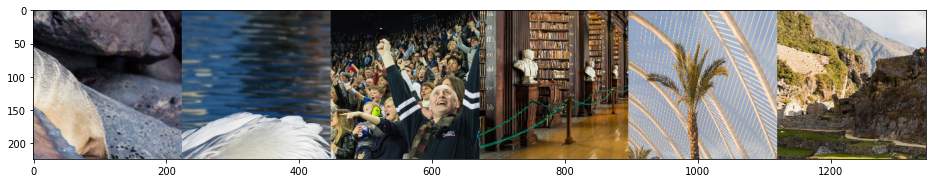

In [ ]:
show_dataset(dataset_content)

# AutoEncoder 

## Model

### Encoder

In [ ]:
from torchvision.models import vgg19 as vgg

class Encoder(nn.Module):
  def __init__(self, pretrained=True):
    super().__init__()

    model = vgg(pretrained=pretrained)

    self.preprocess = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.encoder_0 = nn.Sequential(*model.features[:2])     # relu1_1
    self.encoder_1 = nn.Sequential(*model.features[2:7])    # relu2_1
    self.encoder_2 = nn.Sequential(*model.features[7:12])   # relu3_1
    self.encoder_3 = nn.Sequential(*model.features[12:21])  # relu4_1

    if pretrained:
      for model in [getattr(self, f'encoder_{i}') for i in range(4)]:
        for param in model.parameters():
          param.requires_grad = False

  def forward(self, x):
    results = [self.preprocess(x)]
    for i in range(4):
      x = getattr(self, f'encoder_{i}')(results[-1])
      results.append(x)
    return results[-1]

### Decoder

In [ ]:
class UpScaleBlock(nn.Module):
  def __init__(self, in_dim, out_dim, n_conv_repeat):
    super().__init__()

    modules = [ 
        nn.Conv2d(in_dim, out_dim, (3, 3), padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2),
        nn.Upsample(scale_factor=2, mode='nearest'),
    ]

    for _ in range(n_conv_repeat):
      modules += [
           nn.Conv2d(out_dim, out_dim, (3, 3), padding=1, padding_mode='reflect'), 
           nn.LeakyReLU(0.2)
      ]
    
    self.net = nn.Sequential(*modules)
  
  def forward(self, x):
    return self.net(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        UpScaleBlock(512, 256, 3),
        UpScaleBlock(256, 128, 1),
        UpScaleBlock(128, 64, 1),
        nn.Conv2d(64, 3, (3, 3), padding=1, padding_mode='reflect'),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.net(x)

### Model

In [ ]:
class AutoEncoder(LightningModule):
  def __init__(self, loss_type='pixelwise'):
    super().__init__()
    self.save_hyperparameters()

    if self.hparams.loss_type == 'pixelwise':
      pretrained=False
    elif self.hparams.loss_type == 'content':
      pretrained=True
    else:
      raise 'unsupported loss type'

    self.encoder = Encoder(pretrained=pretrained)
    self.decoder = Decoder() 

    self.mse_loss = nn.MSELoss()

  def forward(self, content):
    feats = self.encoder(content)
    output = self.decoder(feats)
    return output, feats

  def training_step(self, batch, batch_idx):
    input_, _ = batch
    output, input_feats = self(input_)

    if self.hparams.loss_type == 'pixelwise':
      loss = self.mse_loss(input_, output)
    elif self.hparams.loss_type == 'content':
      output_feats = self.encoder(output)
      loss = self.mse_loss(output_feats, input_feats)
    else:
      raise 'unsupported loss type'

    return loss 

  def configure_optimizers(self):
      return Adam(self.parameters(), lr=1e-4)

# Pixelwise loss

## Training

In [ ]:
model = AutoEncoder(loss_type='pixelwise')
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
dataset = dataset_content
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=True)

torch.save(model.state_dict(), 'tmp.pth')
model = AutoEncoder()
model.load_state_dict(torch.load('tmp.pth'))

trainer.fit(model, data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | encoder  | Encoder | 3.5 M 
1 | decoder  | Decoder | 3.5 M 
2 | mse_loss | MSELoss | 0     
-------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
28.044    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluation

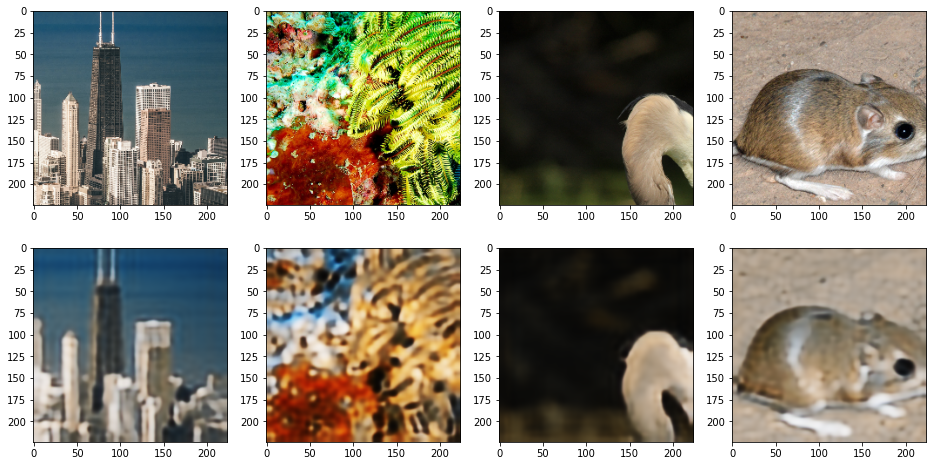

In [ ]:
images = next(iter(data_loader))[0]

fig = plt.figure(figsize=(16, 8))
for i, image in enumerate(images[:4]):
  fig.add_subplot(2, 4, i + 1)
  plt.imshow(image.permute(1, 2, 0))
  fig.add_subplot(2, 4, i + 1 + 4)
  x, y = model(image.unsqueeze(0).float().cuda())
  plt.imshow(x[0].cpu().detach().permute(1, 2, 0))

plt.show()

# Content loss

## Training

In [ ]:
model = AutoEncoder(loss_type='content')
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
dataset = dataset_content
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=True)

torch.save(model.state_dict(), 'tmp.pth')
model = AutoEncoder()
model.load_state_dict(torch.load('tmp.pth'))

trainer.fit(model, data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | encoder  | Encoder | 3.5 M 
1 | decoder  | Decoder | 3.5 M 
2 | mse_loss | MSELoss | 0     
-------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
28.044    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluation

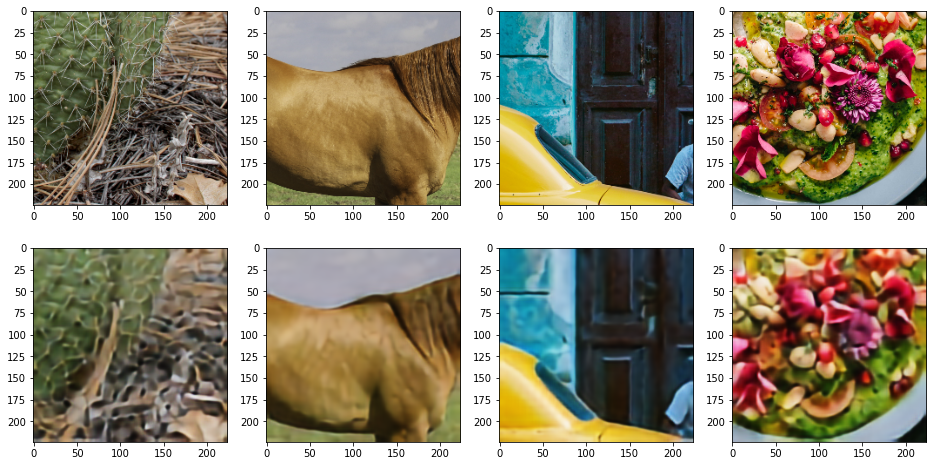

In [ ]:
images = next(iter(data_loader))[0]

fig = plt.figure(figsize=(16, 8))
for i, image in enumerate(images[:4]):
  fig.add_subplot(2, 4, i + 1)
  plt.imshow(image.permute(1, 2, 0))
  fig.add_subplot(2, 4, i + 1 + 4)
  x, y = model(image.unsqueeze(0).float().cuda())
  plt.imshow(x[0].cpu().detach().permute(1, 2, 0))

plt.show()